<a href="https://colab.research.google.com/github/mo-g-19/skinLesionsHAM10000/blob/main/CECS456.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Check that archive/what you name the dataset is in here
!ls -R /content/drive/MyDrive/archive.zip


ls: cannot access '/content/drive/MyDrive/archive.zip': No such file or directory


In [6]:
#I am currently using Google Colab
#To make my life easeir, I am importing the dataset from Google Drive
#If you do not have this dataset downloaded on Google Drive, CHANGE HERE
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/archive.zip" /content/
!unzip /content/archive.zip -d /content/HAM10000


Streaming output truncated to the last 5000 lines.
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029337.jpg  


In [7]:
#Find/make sure the metadata is loaded
!find /content -maxdepth 3 -type f -name "HAM10000_metadata.csv"

/content/HAM10000/HAM10000_metadata.csv


In [8]:
#Checking the GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
#To confirm which GPU have
!nvidia-smi

Thu Dec 18 06:31:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
#Getting all libraries, functions and confirmations
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.19.0
Num GPUs Available: 1


In [11]:
#Setting the paths for the directory, image files, and metadata

# Correct paths
# Base directory where raw HAM10000 parts + metadata are
base_dir = "/content/HAM10000"  # CHANGE if needed

part1_dir = os.path.join(base_dir, "HAM10000_images_part_1")
part2_dir = os.path.join(base_dir, "HAM10000_images_part_2")
metadata_path = os.path.join(base_dir, "HAM10000_metadata.csv")

# Output directory where we'll create /train /val /test
output_root = "/content/data_ham10000"

os.makedirs(output_root, exist_ok=True)

# Load metadata
meta = pd.read_csv(metadata_path)
print(meta.head())
print("Unique diagnosis labels:", meta["dx"].unique())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Unique diagnosis labels: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [12]:
#Building the list of images from part 1 and part 2 image files

image_paths = []
labels = []

missing_count = 0

for _, row in meta.iterrows():
    image_id = row["image_id"]  # e.g. 'ISIC_0024306'
    label = row["dx"]           # e.g. 'mel'
    filename = image_id + ".jpg"

    p1 = os.path.join(part1_dir, filename)
    p2 = os.path.join(part2_dir, filename)

    if os.path.exists(p1):
        img_path = p1
    elif os.path.exists(p2):
        img_path = p2
    else:
        missing_count += 1
        continue

    image_paths.append(img_path)
    labels.append(label)

print("Total images found:", len(image_paths))
print("Missing images:", missing_count)
classes = sorted(list(set(labels)))
#Should have 7 classes
print("Classes:", classes)

Total images found: 10015
Missing images: 0
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [13]:
#If want a random seed, use time
import time

# Fix random seeds for some reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [14]:
#Splitting the dataset into train:val:test repectively 70:15:15


test_size = 0.15
val_size  = 0.15

X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels,
    test_size=test_size,
    stratify=labels,
    random_state=seed
)

val_ratio_of_temp = val_size / (1.0 - test_size)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio_of_temp,
    stratify=y_temp,
    random_state=seed
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))


Train size: 7009
Val size: 1503
Test size: 1503


In [15]:
#Create folder structure and copy images:
import shutil

splits = ["train", "val", "test"]

for split in splits:
    for cls in classes:
        out_dir = os.path.join(output_root, split, cls)
        os.makedirs(out_dir, exist_ok=True)

def copy_images(file_paths, labels, split_name):
    for src, label in zip(file_paths, labels):
        fname = os.path.basename(src)
        dest_dir = os.path.join(output_root, split_name, label)
        dest_path = os.path.join(dest_dir, fname)
        shutil.copy2(src, dest_path)
    print(f"Copied {len(file_paths)} images to {split_name}/")

copy_images(X_train, y_train, "train")
copy_images(X_val,   y_val,   "val")
copy_images(X_test,  y_test,  "test")


Copied 7009 images to train/
Copied 1503 images to val/
Copied 1503 images to test/


In [16]:
#Sanity check that it works
for split in splits:
    for cls in classes:
        path = os.path.join(output_root, split, cls)
        print(split, cls, "->", len(os.listdir(path)))

#As you can see below, the dataset is not evenly represented
#Need to fix to make sure not skewed towards the classes with more data

train akiec -> 229
train bcc -> 360
train bkl -> 769
train df -> 80
train mel -> 779
train nv -> 4693
train vasc -> 99
val akiec -> 49
val bcc -> 77
val bkl -> 165
val df -> 18
val mel -> 167
val nv -> 1006
val vasc -> 21
test akiec -> 49
test bcc -> 77
test bkl -> 165
test df -> 17
test mel -> 167
test nv -> 1006
test vasc -> 22


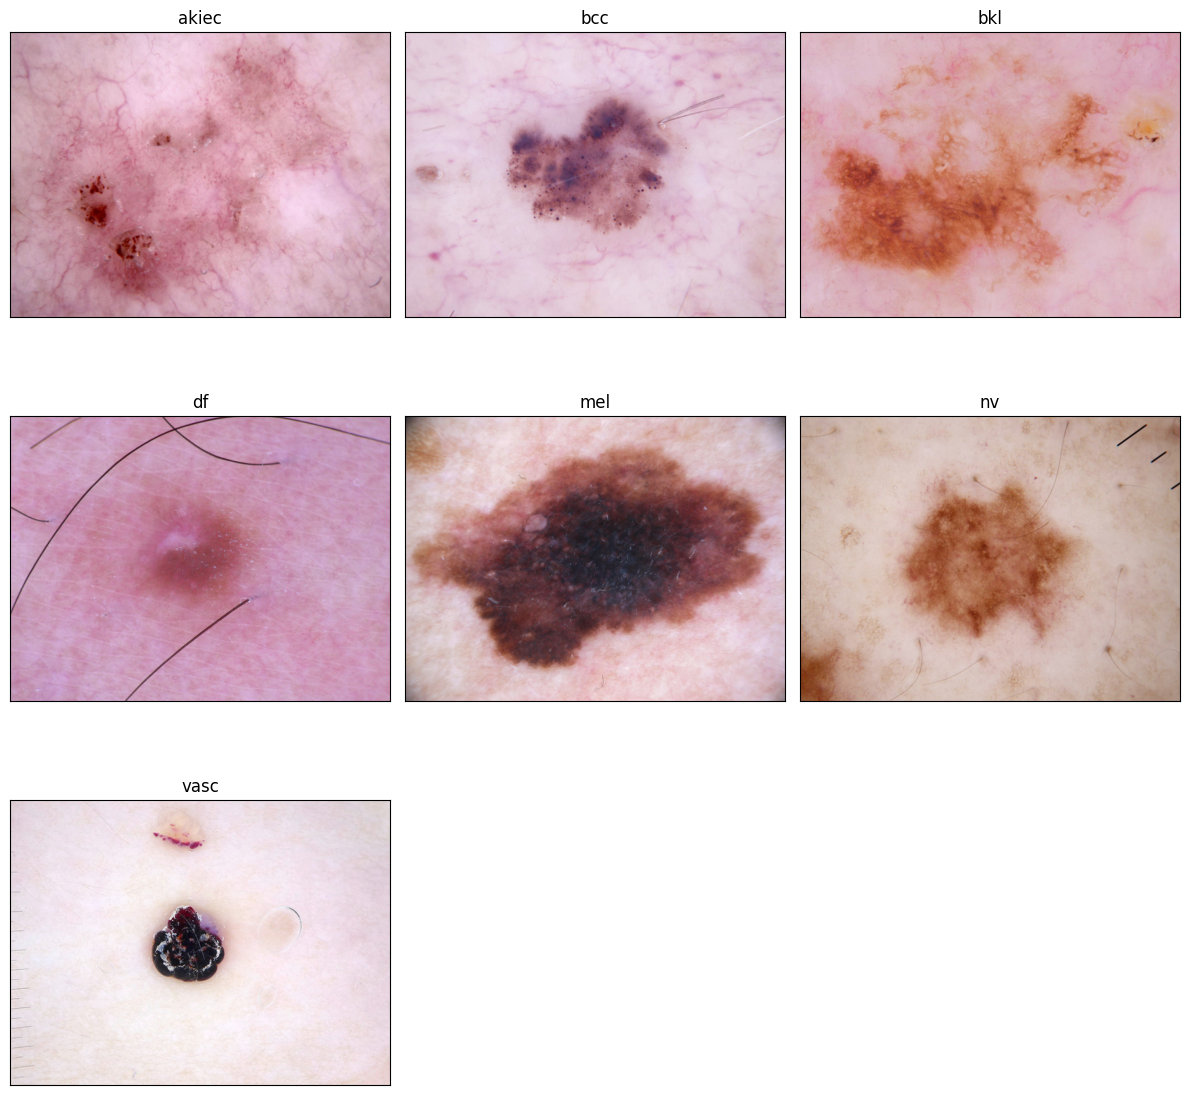

In [17]:
#Visualize the seven classes training the model on
import matplotlib.image as mpimg
import random

# Directory where your split dataset lives
train_dir = os.path.join(output_root, "train")

plt.figure(figsize=(12, 12))

for idx, cls in enumerate(classes):
    class_dir = os.path.join(train_dir, cls)
    images = os.listdir(class_dir)

    # Pick a random sample from the class folder
    sample_img = random.choice(images)
    img_path = os.path.join(class_dir, sample_img)

    # Load image
    img = mpimg.imread(img_path)

    # Plot
    plt.subplot(3, 3, idx+1)  # 7 classes → 3×3 grid is sufficient
    plt.imshow(img)
    plt.title(cls)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

plt.tight_layout()
plt.show()

In [18]:
#Making TensorFlow Datasets

img_size   = (224, 224)
batch_size = 32

train_dir = os.path.join(output_root, "train")
val_dir   = os.path.join(output_root, "val")
test_dir  = os.path.join(output_root, "test")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False  # important for metrics
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names, "Num classes:", num_classes)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 7009 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.
Class names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] Num classes: 7


This is the ResNet50 model. Further down, I'll compare ResNet101

In [ ]:
#ResNet50 model without self attention

#Data aumentation for ResNet50 model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Simple data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)


# Base ResNet50 (ImageNet weights)
base_model_res = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_size + (3,)
)
base_model_res.trainable = False  # first training phase: frozen

inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

# Continuing with the general GAP and Dropout
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(0.3, name="dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model50_base = keras.Model(inputs, outputs, name="ResNet50_HAM10000_Base")

model50_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50_HAM10000_Base"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 7)         │     14,343 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
#Making a Squeeze-and-Excitation block for my channel attention
from tensorflow.keras import layers

def se_block(x, reduction_ratio=16, name=None):
    """
    Squeeze-and-Excitation block (channel attention).
    x: 4D tensor (batch, H, W, C)
    reduction_ratio: how much to reduce channel dimension in the bottleneck
    """
    channels = x.shape[-1]
    if channels is None:
        raise ValueError("Input tensor to SE block must have known channel dimension")

    se_name = "" if name is None else name + "_"

    # Squeeze: global average pooling over spatial dimensions
    se = layers.GlobalAveragePooling2D(name=se_name + "squeeze")(x)

    # Excitation: bottleneck MLP
    se = layers.Dense(
        units=channels // reduction_ratio,
        activation="relu",
        name=se_name + "excitation_dense1"
    )(se)
    se = layers.Dense(
        units=channels,
        activation="sigmoid",
        name=se_name + "excitation_dense2"
    )(se)

    # Reshape to (batch, 1, 1, C) so we can multiply
    se = layers.Reshape((1, 1, channels), name=se_name + "reshape")(se)

    # Scale: channel-wise multiplication
    x = layers.Multiply(name=se_name + "scale")([x, se])

    return x

In [21]:
#Data aumentation for ResNet50 model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Simple data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)

# Base ResNet50 (ImageNet weights)
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_size + (3,)
)
base_model.trainable = False  # first training phase: frozen

inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

#Adding channel-attention (not self-attention)
#specific for CNNs (what doing now)
#Choose standard SE block
x = se_block(x, reduction_ratio=16, name="resnet50_se")

# Continuing with the general GAP and Dropout
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(0.3, name="dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model50 = keras.Model(inputs, outputs, name="ResNet50_HAM10000")

model50.summary()


Model: "ResNet50_HAM10000"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_se_squeeze │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_se_excita… │ (None, 128)       │    262,272 │ resnet50_se_sque… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_se_excita… │ (None, 2048)      │    264,192 │ resnet50_se_exci… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_se_reshape │ (None, 1, 1,      │          0 │ resnet50_se_exci… │
│ (Reshape)           │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_se_scale   │ (None, 7, 7,      │          0 │ resnet50[0][0],   │
│ (Multiply)          │ 2048)             │            │ resnet50_se_resh… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 2048)      │          0 │ resnet50_se_scal… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 7)         │     14,343 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,128,519 (92.04 MB)

 Trainable params: 540,807 (2.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Now training and evaluating both models with a funciton

In [22]:
from inspect import EndOfBlock

def train_and_evaluate(model, train_ds, val_ds, test_ds,
                       initial_lr=1e-4, epochs=15, model_tag="model"):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    checkpoint_path = f"/content/{model_tag}_best.keras"

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
    ]

    #Start timing
    start_time = time.time()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    #End timing
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Training time for {model_tag}: {elapsed_time:.2f} seconds")
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"{model_tag} -> Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

    return history, test_loss, test_acc, elapsed_time

In [23]:
#Modify from the ResNet50 with SE and ResNet50 comparison
#For the baseline ResNet
results = {}
histories = {}


#ResNet50 model
history_50_base, loss_50_base, acc_50_base, time_50_base = train_and_evaluate(
    model50_base,
    train_ds, val_ds, test_ds,
    initial_lr=1e-4,
    epochs=15,
    model_tag="resnet50_base"
)

results["resnet50_base"] = {
    "test_loss": loss_50_base,
    "test_acc": acc_50_base,
    "train_time_sec": time_50_base,
    "lr": 1e-4,
    "epochs": 15,
}

histories["resnet50_base"] = history_50_base

print(results)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.3950 - loss: 1.9945
Epoch 1: val_accuracy improved from -inf to 0.67532, saving model to /content/resnet50_base_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 242ms/step - accuracy: 0.3956 - loss: 1.9922 - val_accuracy: 0.6753 - val_loss: 1.0372
Epoch 2/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6540 - loss: 1.0910
Epoch 2: val_accuracy improved from 0.67532 to 0.68596, saving model to /content/resnet50_base_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 48s 219ms/step - accuracy: 0.6540 - loss: 1.0907 - val_accuracy: 0.6860 - val_loss: 0.8930
Epoch 3/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6772 - loss: 0.9538
Epoch 3: val_accuracy improved from 0.68596 to 0.70858, saving model to /content/resnet50_base_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 79s 207ms/step - accuracy: 0.6773 - loss: 0.9536 - val_accuracy: 0.7086 - val_loss: 0.8206
Epoch 4/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accur

In [24]:
#ResNet50 model
history_50_lr4, loss_50, acc_50, time_50 = train_and_evaluate(
    model50,
    train_ds, val_ds, test_ds,
    initial_lr=1e-4,
    epochs=15,
    model_tag="resnet50_lr4"
)

results["resnet50_lr4"] = {
    "test_loss": loss_50,
    "test_acc": acc_50,
    "train_time_sec": time_50,
    "lr": 1e-4,
    "epochs": 15,
}

histories["resnet50_lr4"] = history_50_lr4

print(results)

Epoch 1/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5630 - loss: 1.2872
Epoch 1: val_accuracy improved from -inf to 0.72056, saving model to /content/resnet50_lr4_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - accuracy: 0.5638 - loss: 1.2850 - val_accuracy: 0.7206 - val_loss: 0.7799
Epoch 2/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7084 - loss: 0.8220
Epoch 2: val_accuracy improved from 0.72056 to 0.73453, saving model to /content/resnet50_lr4_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 77s 208ms/step - accuracy: 0.7085 - loss: 0.8217 - val_accuracy: 0.7345 - val_loss: 0.7186
Epoch 3/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7270 - loss: 0.7571
Epoch 3: val_accuracy improved from 0.73453 to 0.74983, saving model to /content/resnet50_lr4_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 45s 203ms/step - accuracy: 0.7271 - loss: 0.7569 - val_accuracy: 0.7498 - val_loss: 0.6807
Epoch 4/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy

This is a function to visualize the confusion matrix

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def save_confusion_matrix(model, test_ds, class_names, out_path):
    # collect true labels
    y_true = []
    for _, labels in test_ds:
        y_true.append(labels.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_true_labels = np.argmax(y_true, axis=1)

    # predictions
    y_pred_probs = model.predict(test_ds)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    print("Confusion matrix:\n", cm)

    # plot
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="True label",
        xlabel="Predicted label",
        title="Confusion Matrix",
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    fig.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print("Saved confusion matrix to:", out_path)


In [28]:
#The base model confusion matrix
save_confusion_matrix(
    resnet50_base,                # or model50 if it's still in memory
    test_ds,
    class_names,
    "/content/confusion_matrix_resnet50_base.png"
)

NameError: name 'resnet50_base' is not defined

47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step
Confusion matrix:
 [[ 14   7  14   2   7   5   0]
 [  6  24  15   0  11  21   0]
 [  2   1 105   0  18  39   0]
 [  1   0   2   3   3   8   0]
 [  2   0  15   0  82  68   0]
 [  1   5  29   0  37 933   1]
 [  0   0   2   0   3   8   9]]


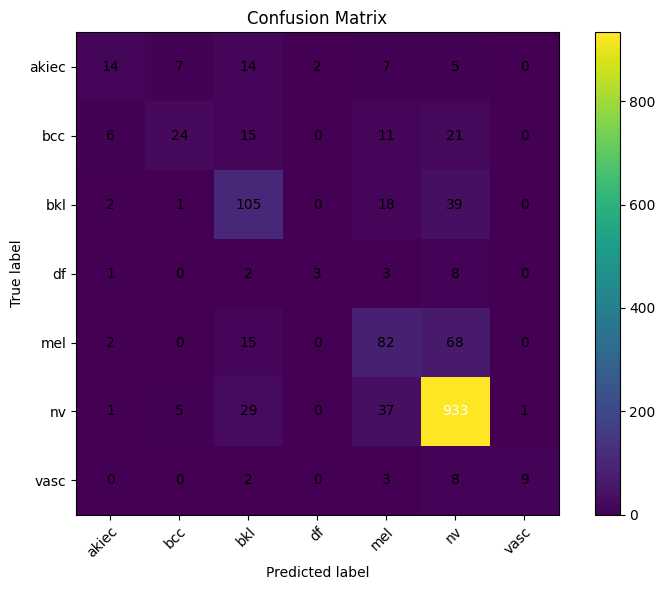

Saved confusion matrix to: /content/confusion_matrix_resnet50.png


In [29]:
# For your ResNet50-SE model
save_confusion_matrix(
    model50,                # or model50 if it's still in memory
    test_ds,
    class_names,
    "/content/confusion_matrix_resnet50.png"
)

In [ ]:
#The

In [22]:
#The VGG-style with self-attention

img_size = (224, 224)
input_shape = img_size + (3,)

inputs = keras.Input(shape=input_shape)

# --- VGG-like feature extractor ---
x = layers.Rescaling(1./255)(inputs)

# Block 1
x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 2
x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 3
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

# --- Simple self-attention over spatial positions ---
# Flatten H×W into sequence, keep channels as features
h, w = x.shape[1], x.shape[2]
c = x.shape[3]

x_reshaped = layers.Reshape((h * w, c))(x)  # (batch, seq_len, channels)

attn = layers.MultiHeadAttention(
  num_heads=4,
  key_dim=c // 4,           # small head size
  dropout=0.1
  )(x_reshaped, x_reshaped)

# Add & norm (Transformer-style)
x_attn = layers.Add()([x_reshaped, attn])
x_attn = layers.LayerNormalization()(x_attn)

# Pool over sequence (global average)
x_pooled = layers.GlobalAveragePooling1D()(x_attn)

# --- Classifier head ---
x_pooled = layers.Dropout(0.5)(x_pooled)
x_pooled = layers.Dense(128, activation="relu")(x_pooled)
x_pooled = layers.Dropout(0.5)(x_pooled)

outputs = layers.Dense(num_classes, activation="softmax")(x_pooled)

modelvgg = keras.Model(inputs, outputs, name="VGG_Attention_HAM10000")

modelvgg.summary()

Model: "VGG_Attention_HAM10000"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 784, 128)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 784, 128)  │     66,048 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 784, 128)  │          0 │ reshape[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 784, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 370,727 (1.41 MB)

 Trainable params: 370,727 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#Vgg model
history_vgg_att_lr4, loss_vgg_att, acc_vgg_att, time_vgg_att = train_and_evaluate(
    modelvgg,
    train_ds, val_ds, test_ds,
    initial_lr=1e-4,
    epochs=15,
    model_tag="vgg_attention"
)

results["vgg_lr4"] = {
    "test_loss": loss_vgg_att,
    "test_acc": acc_vgg_att,
    "train_time_sec": time_vgg_att,
    "lr": 1e-4,
    "epochs": 15,
}

histories["history_vgg_att_lr4"] = history_vgg_att_lr4

print(results)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6187 - loss: 1.3196
Epoch 1: val_accuracy improved from -inf to 0.66933, saving model to /content/vgg_attention_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 292ms/step - accuracy: 0.6189 - loss: 1.3190 - val_accuracy: 0.6693 - val_loss: 1.0252
Epoch 2/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6609 - loss: 1.1042
Epoch 2: val_accuracy did not improve from 0.66933
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 199ms/step - accuracy: 0.6609 - loss: 1.1040 - val_accuracy: 0.6693 - val_loss: 0.9868
Epoch 3/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6673 - loss: 1.0463
Epoch 3: val_accuracy did not improve from 0.66933
220/220 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.6672 - loss: 1.0462 - val_accuracy: 0.6693 - val_loss: 0.9904
Epoch 4/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6640 - loss: 1.0069
Epoch 4: val_accuracy did not improve from 0.66933
220/220 ━━━━━━━━━━━━━━━━━━━━ 43s

In [29]:
!ls /content/*best.keras

!mkdir -p /content/drive/MyDrive/ham10000_models
!mkdir -p /content/drive/MyDrive/ham10000_results


/content/resnet50_lr4_best.keras  /content/vgg_attention_best.keras


In [33]:
#Saving my code
!cp /content/resnet50_lr4_best.keras /content/drive/MyDrive/ham10000_models/
!cp /content/vgg_attention_best.keras /content/drive/MyDrive/ham10000_models/

# Copy metrics and plots
#!cp -r /content/results/* /content/drive/MyDrive/ham10000_results/  # if you used /content/results
!cp /content/confusion_matrix_resnet50.png /content/drive/MyDrive/ham10000_results/  2>/dev/null
!cp /content/confusion_matrix_vgg_attention.png /content/drive/MyDrive/ham10000_results/    2>/dev/null

#Eventually do the same when I finish the baselines

In [34]:
!ls -lh /content/drive/MyDrive/ham10000_models
!ls -lh /content/drive/MyDrive/ham10000_results


total 102M
-rw------- 1 root root  97M Dec 17 17:48 resnet50_lr4_best.keras
-rw------- 1 root root 4.4M Dec 17 17:48 vgg_attention_best.keras
total 0


In [35]:
import os

print(os.path.exists('/content/drive/MyDrive/ham10000_models'))
print(os.path.exists('/content/drive/MyDrive/ham10000_results'))


True
True


In [37]:
from tensorflow import keras

resnet_model = keras.models.load_model(
    "/content/drive/MyDrive/ham10000_models/resnet50_lr4_best.keras"
)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step
Confusion matrix:
 [[ 18   7  13   2   6   3   0]
 [  3  33  15   0   9  17   0]
 [  2   1 110   0  17  35   0]
 [  1   1   2   5   2   6   0]
 [  2   0  27   0  94  44   0]
 [  2   6  37   1  52 907   1]
 [  0   1   3   0   3   5  10]]


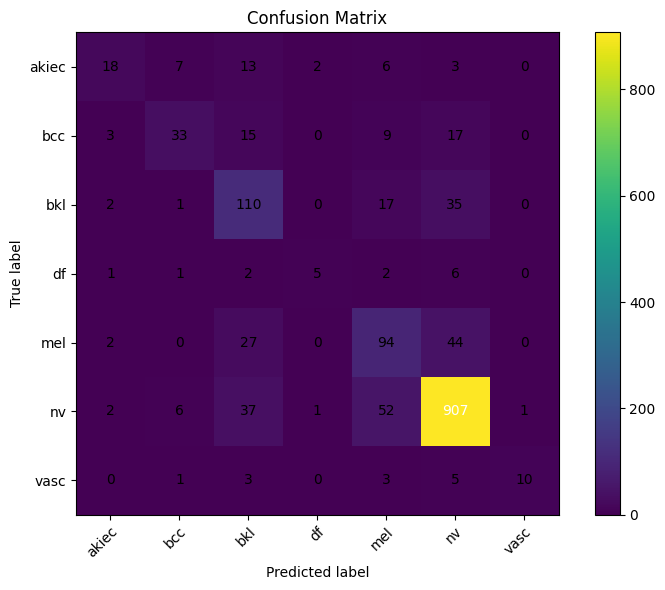

Saved confusion matrix to: /content/confusion_matrix_resnet50.png
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step
Confusion matrix:
 [[  1   7   7   0   0  34   0]
 [  1  12   9   0   0  53   2]
 [  0   4  42   0   1 118   0]
 [  1   3   2   0   0  10   1]
 [  0   4  14   0   6 142   1]
 [  1   3  11   0   6 983   2]
 [  0   6   2   0   0   8   6]]


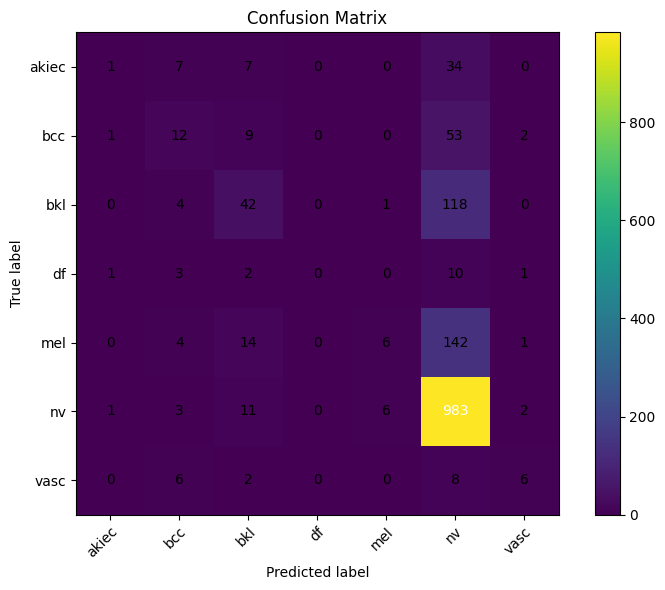

Saved confusion matrix to: /content/confusion_matrix_vgg_sa.png


In [40]:
# For your ResNet50-SE model
save_confusion_matrix(
    resnet_model,                # or model50 if it's still in memory
    test_ds,
    class_names,
    "/content/confusion_matrix_resnet50.png"
)

# For your VGG + self-attention model (if you want)
vgg_model = keras.models.load_model(
    "/content/drive/MyDrive/ham10000_models/vgg_attention_best.keras"
)
save_confusion_matrix(
    vgg_model,
    test_ds,
    class_names,
    "/content/confusion_matrix_vgg_sa.png"
)
